# Airline Customer Analytics

**Data Feature Exploration**

**Date:** 20 Jan, 2026

---

## Importing Required Packages

In [1]:
# --- Data Analysis ---
import pandas as pd
import numpy as np

# --- Data Visualization ---
import matplotlib.pyplot as plt

---

## Exploratory Data Analytics

### Load Data

In [2]:
cfa_df = pd.read_parquet(
    "../data/processed/cfa.parquet",
    engine="pyarrow"
)

cfa_df.head()

,loyalty_number,year,month,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed
0,100590,2018,6,12,15276,22914.0,0,0
1,100590,2018,7,12,9168,13752.0,0,0
2,100590,2018,5,4,6504,9756.0,0,0
3,100590,2018,10,0,0,0.0,512,92
4,100590,2018,2,0,0,0.0,0,0


In [3]:
clh_df = pd.read_parquet(
    "../data/processed/clh.parquet",
    engine="pyarrow"
)

clh_df.head()

,loyalty_number,country,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month,cancellation_year,cancellation_month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,<NA>,<NA>
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,<NA>,<NA>
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Single,Star,3839.75,Standard,2014,7,2018,1
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,NaN,Single,Star,3839.75,Standard,2013,2,<NA>,<NA>
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,2014,10,<NA>,<NA>


In [4]:
clh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   loyalty_number      16737 non-null  int64  
 1   country             16737 non-null  string 
 2   province            16737 non-null  string 
 3   city                16737 non-null  string 
 4   postal_code         16737 non-null  string 
 5   gender              16737 non-null  string 
 6   education           16737 non-null  string 
 7   salary              12499 non-null  float64
 8   marital_status      16737 non-null  string 
 9   loyalty_card        16737 non-null  string 
 10  clv                 16737 non-null  float64
 11  enrollment_type     16737 non-null  string 
 12  enrollment_year     16737 non-null  int64  
 13  enrollment_month    16737 non-null  int64  
 14  cancellation_year   2067 non-null   Int64  
 15  cancellation_month  2067 non-null   Int64  
dtypes: I

### Total No of Customers

In [5]:
clh_df["loyalty_number"].nunique()

16737

### RFM

In [6]:
customers = cfa_df[['loyalty_number']].drop_duplicates()

cfa_df['activity_date'] = pd.to_datetime(
    dict(year=cfa_df['year'], month=cfa_df['month'], day=1)
)

max_activity_date = cfa_df["activity_date"].max()

In [7]:
print("Activity date range in cfa_df:")
print("Min:", cfa_df["activity_date"].min())
print("Max:", cfa_df["activity_date"].max())

Activity date range in cfa_df:
Min: 2017-01-01 00:00:00
Max: 2018-12-01 00:00:00


#### Recency

In [8]:
recent_activity = (
    cfa_df[cfa_df['total_flights'] > 0]
    .sort_values('activity_date')
    .groupby('loyalty_number', as_index=False)
    .last()[['loyalty_number', 'activity_date', 'total_flights']]
)

recent_activity["recency"] = (
    (max_activity_date.year - recent_activity["activity_date"].dt.year) * 12
    + (max_activity_date.month - recent_activity["activity_date"].dt.month)
)

customer_recency = customers.merge(
    recent_activity[['loyalty_number', 'recency']],
    on='loyalty_number',
    how='left'
)

max_recency = customer_recency['recency'].max()
customer_recency['recency'] = (
    customer_recency['recency'].fillna(max_recency + 1)
).astype('int64')

max_r = customer_recency['recency'].max()
min_r = customer_recency['recency'].min()

customer_recency['recency_score_continuous'] = (
    1 - (customer_recency['recency'] - min_r) / (max_r - min_r)
).round(3)

customer_recency['recency_score_discrete'] = pd.cut(
    customer_recency['recency'],
    bins=[-1, 1, 3, 6, 12, 24],
    labels=[5, 4, 3, 2, 1]
).astype('int64')

customer_recency.head()

,loyalty_number,recency,recency_score_continuous,recency_score_discrete
0,100590,5,0.792,3
1,102376,0,1.000,5
2,102788,0,1.000,5
3,104267,0,1.000,5
4,105063,1,0.958,5


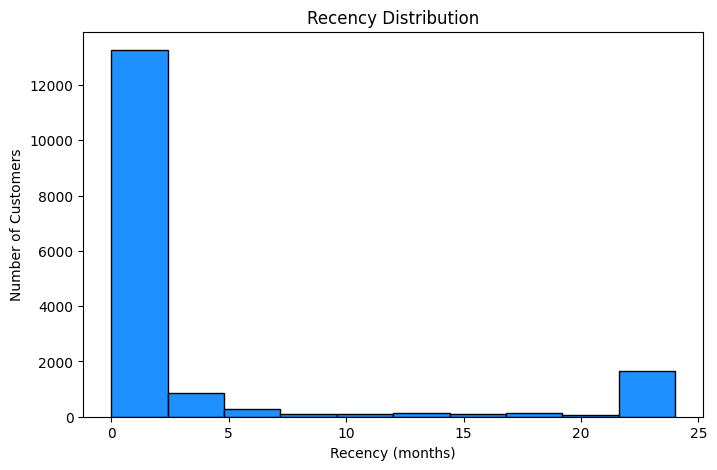

In [9]:
plt.figure(figsize=(8, 5))
plt.hist(customer_recency["recency"], bins=10, color="dodgerblue", edgecolor="black")
plt.title("Recency Distribution")
plt.xlabel("Recency (months)")
plt.ylabel("Number of Customers")
plt.show()

#### Frequency

In [10]:
flight_frequency = (
    cfa_df
    .groupby('loyalty_number', as_index=False)
    .agg(frequency=('total_flights', 'sum'))
)

active_month_frequency = (
    cfa_df[cfa_df['total_flights'] > 0]
    .groupby('loyalty_number', as_index=False)
    .agg(active_months=('activity_date', 'nunique'))
)

customer_frequency = flight_frequency.merge(
    active_month_frequency,
    on='loyalty_number',
    how='left'
)

customer_frequency['active_months'] = (
    customer_frequency['active_months'].fillna(0)
)

customer_frequency['frequency_score_discrete'] = pd.qcut(
    customer_frequency['frequency'],
    q=5,
    labels=[1, 2, 3, 4, 5]
).astype('int64')

max_frequency = customer_frequency['frequency'].max()

customer_frequency['frequency_score_continuous'] = (
    customer_frequency['frequency'] / max_frequency
)

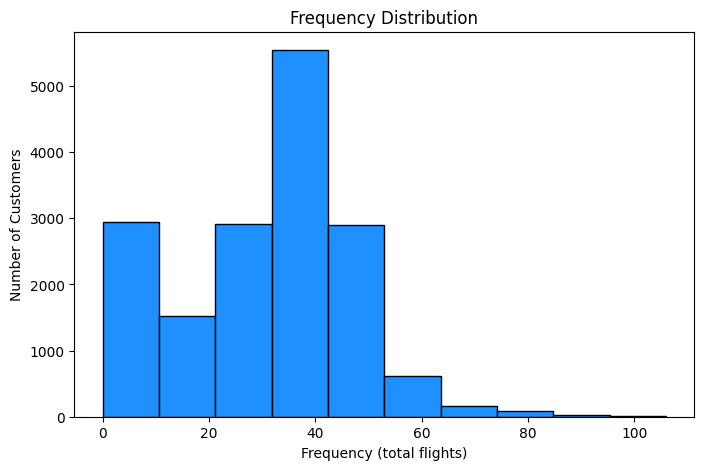

In [11]:
plt.figure(figsize=(8, 5))
plt.hist(customer_frequency["frequency"], bins=10, color="dodgerblue", edgecolor="black")
plt.title("Frequency Distribution")
plt.xlabel("Frequency (total flights)")
plt.ylabel("Number of Customers")
plt.show()

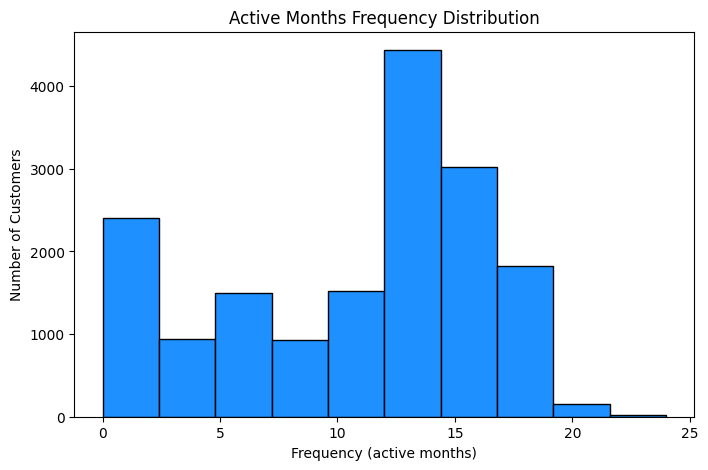

In [12]:
plt.figure(figsize=(8, 5))
plt.hist(customer_frequency["active_months"], bins=10, color="dodgerblue", edgecolor="black")
plt.title("Active Months Frequency Distribution")
plt.xlabel("Frequency (active months)")
plt.ylabel("Number of Customers")
plt.show()

In [13]:
customer_frequency.head()

,loyalty_number,frequency,active_months,frequency_score_discrete,frequency_score_continuous
0,100018,46,18.0,5,0.433962
1,100102,51,17.0,5,0.481132
2,100140,47,17.0,5,0.443396
3,100214,22,9.0,2,0.207547
4,100272,37,13.0,3,0.349057


#### Monetary

In [14]:
monetary_distance = (
    cfa_df[cfa_df['total_flights'] > 0]
    .groupby('loyalty_number', as_index=False)
    .agg(
        monetary=('distance', 'sum')
    )
)

customer_monetary = customers.merge(
    monetary_distance,
    on='loyalty_number',
    how='left'
)

customer_monetary['monetary'] = (
    customer_monetary['monetary'].fillna(0).astype('int64')
)

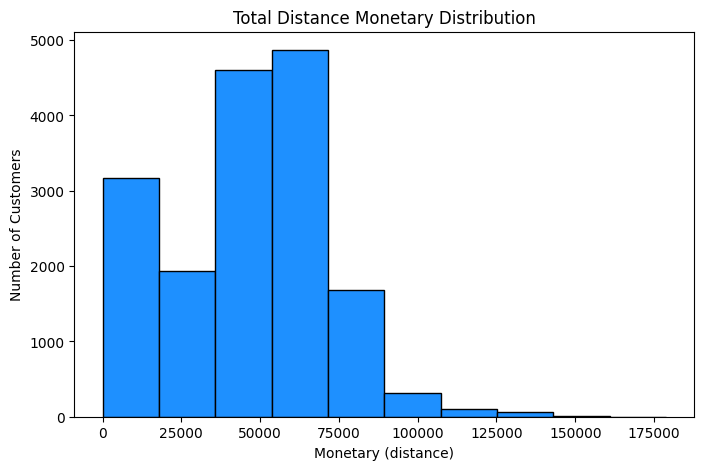

In [15]:
plt.figure(figsize=(8, 5))
plt.hist(customer_monetary["monetary"], bins=10, color="dodgerblue", edgecolor="black")
plt.title("Total Distance Monetary Distribution")
plt.xlabel("Monetary (distance)")
plt.ylabel("Number of Customers")
plt.show()

In [16]:
max_distance = monetary_distance['monetary'].max()

customer_monetary['monetary_score_continuous'] = (
    customer_monetary['monetary'] / max_distance
)

customer_monetary['monetary_score_discrete'] = pd.qcut(
    customer_monetary['monetary'],
    q=5,
    labels=[1, 2, 3, 4, 5]
).astype('int64')

In [17]:
customer_monetary.head()

,loyalty_number,monetary,monetary_score_continuous,monetary_score_discrete
0,100590,30948,0.173031,2
1,102376,79580,0.444934,5
2,102788,135657,0.758462,5
3,104267,61606,0.344441,4
4,105063,40695,0.227527,2


#### RFM Table

In [18]:
rfm_df = (
    customers
    .merge(
        customer_recency[['loyalty_number', 'recency', 'recency_score_discrete']].rename(columns={'recency_score_discrete': 'r_score'}),
        on='loyalty_number',
        how='left'
    )
    .merge(
        customer_frequency[['loyalty_number', 'frequency', 'frequency_score_discrete']].rename(columns={'frequency_score_discrete': 'f_score'}),
        on='loyalty_number',
        how='left'
    )
    .merge(
        customer_monetary[['loyalty_number', 'monetary', 'monetary_score_discrete']].rename(columns={'monetary_score_discrete': 'm_score'}),
        on='loyalty_number',
        how='left'
    )
)

In [19]:
def rfm_segment(row):
    r = row['r_score']
    f = row['f_score']
    m = row['m_score']

    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    elif r >= 3 and f >= 3:
        return 'Loyal'
    elif r <= 2 and f >= 3:
        return 'At Risk'
    elif r <= 2 and f <= 2:
        return 'Dormant'
    else:
        return 'Potential'

rfm_df['rfm_segment'] = rfm_df.apply(rfm_segment, axis=1)


In [20]:
rfm_df['rfm'] = (
    rfm_df['r_score'].astype(int).astype(str) +
    rfm_df['f_score'].astype(int).astype(str) +
    rfm_df['m_score'].astype(int).astype(str)
)

In [21]:
rfm_df.groupby('rfm_segment')['rfm'].nunique()

rfm_segment
At Risk       8
Champions     8
Dormant      10
Loyal        27
Potential    18
Name: rfm, dtype: int64

In [22]:
rfm_df.drop(columns='rfm', inplace=True)
rfm_df["rfm_segment"] = rfm_df["rfm_segment"].astype("string")
rfm_df.head()

,loyalty_number,recency,r_score,frequency,f_score,monetary,m_score,rfm_segment
0,100590,5,3,28,2,30948,2,Potential
1,102376,0,5,73,5,79580,5,Champions
2,102788,0,5,84,5,135657,5,Champions
3,104267,0,5,38,4,61606,4,Champions
4,105063,1,5,27,2,40695,2,Potential


In [23]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   loyalty_number  16737 non-null  int64 
 1   recency         16737 non-null  int64 
 2   r_score         16737 non-null  int64 
 3   frequency       16737 non-null  int64 
 4   f_score         16737 non-null  int64 
 5   monetary        16737 non-null  int64 
 6   m_score         16737 non-null  int64 
 7   rfm_segment     16737 non-null  string
dtypes: int64(7), string(1)
memory usage: 1.0 MB


In [24]:
clh_df["is_cancelled"] = clh_df["cancellation_year"].notna()

clh_df["enrollment_date"] = pd.to_datetime(
    dict(
        year=clh_df["enrollment_year"],
        month=clh_df["enrollment_month"],
        day=1
    )
)

clh_df["cancellation_date"] = pd.NaT
mask = clh_df["is_cancelled"]

clh_df.loc[mask, "cancellation_date"] = pd.to_datetime(
    dict(
        year=clh_df.loc[mask, "cancellation_year"].astype(int),
        month=clh_df.loc[mask, "cancellation_month"].astype(int),
        day=1
    )
)

reference_date = max_activity_date

clh_df["tenure_end_date"] = np.where(
    clh_df["is_cancelled"],
    clh_df["cancellation_date"],
    reference_date
)

clh_df["tenure_end_date"] = pd.to_datetime(clh_df["tenure_end_date"])

clh_df["tenure_months"] = (
    (clh_df["tenure_end_date"].dt.year - clh_df["enrollment_date"].dt.year) * 12
    + (clh_df["tenure_end_date"].dt.month - clh_df["enrollment_date"].dt.month)
)

clh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   loyalty_number      16737 non-null  int64         
 1   country             16737 non-null  string        
 2   province            16737 non-null  string        
 3   city                16737 non-null  string        
 4   postal_code         16737 non-null  string        
 5   gender              16737 non-null  string        
 6   education           16737 non-null  string        
 7   salary              12499 non-null  float64       
 8   marital_status      16737 non-null  string        
 9   loyalty_card        16737 non-null  string        
 10  clv                 16737 non-null  float64       
 11  enrollment_type     16737 non-null  string        
 12  enrollment_year     16737 non-null  int64         
 13  enrollment_month    16737 non-null  int64     

In [25]:
clh = clh_df[["loyalty_number", "province", "city","gender", "education", "loyalty_card", "clv", "is_cancelled", "tenure_months"]].copy()
clh.head()

,loyalty_number,province,city,gender,education,loyalty_card,clv,is_cancelled,tenure_months
0,480934,Ontario,Toronto,Female,Bachelor,Star,3839.14,False,34
1,549612,Alberta,Edmonton,Male,College,Star,3839.61,False,33
2,429460,British Columbia,Vancouver,Male,College,Star,3839.75,True,42
3,608370,Ontario,Toronto,Male,College,Star,3839.75,False,70
4,530508,Quebec,Hull,Male,Bachelor,Star,3842.79,False,50


In [26]:
customer_features = clh.merge(
    rfm_df,
    on="loyalty_number",
    how="left"
)

In [27]:
customer_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   loyalty_number  16737 non-null  int64  
 1   province        16737 non-null  string 
 2   city            16737 non-null  string 
 3   gender          16737 non-null  string 
 4   education       16737 non-null  string 
 5   loyalty_card    16737 non-null  string 
 6   clv             16737 non-null  float64
 7   is_cancelled    16737 non-null  bool   
 8   tenure_months   16737 non-null  int32  
 9   recency         16737 non-null  int64  
 10  r_score         16737 non-null  int64  
 11  frequency       16737 non-null  int64  
 12  f_score         16737 non-null  int64  
 13  monetary        16737 non-null  int64  
 14  m_score         16737 non-null  int64  
 15  rfm_segment     16737 non-null  string 
dtypes: bool(1), float64(1), int32(1), int64(7), string(6)
memory usage: 1.9 MB


In [28]:
customer_features.head()

,loyalty_number,province,city,gender,education,loyalty_card,clv,is_cancelled,tenure_months,recency,r_score,frequency,f_score,monetary,m_score,rfm_segment
0,480934,Ontario,Toronto,Female,Bachelor,Star,3839.14,False,34,0,5,37,3,54525,3,Loyal
1,549612,Alberta,Edmonton,Male,College,Star,3839.61,False,33,0,5,58,5,77487,5,Champions
2,429460,British Columbia,Vancouver,Male,College,Star,3839.75,True,42,11,2,18,2,24803,2,Dormant
3,608370,Ontario,Toronto,Male,College,Star,3839.75,False,70,0,5,35,3,48432,3,Loyal
4,530508,Quebec,Hull,Male,Bachelor,Star,3842.79,False,50,0,5,37,3,55515,4,Loyal


In [29]:
customer_features.to_parquet("../data/curated/customer_features.parquet", index=False)